# Zillow Project
#

## Setup

In [1]:
# initial imports
import wrangle
from wrangle import wrangle_zillow, split_clean_zillow, x_y_split
import model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.metrics import explained_variance_score
import warnings

warnings.filterwarnings('ignore')

#
# Wrangle

In [2]:
# Bring in the zillow data using the wrangle module
zillow_df = wrangle_zillow()

The zillow data has been acquired, cleaned, and stored in the zillow_df dataframe


In [3]:
zillow_df.head(3)

,square_feet,bedrooms,home_value
0,3100.0,4.0,1023282.0
1,1465.0,2.0,464000.0
2,1243.0,3.0,564778.0


In [4]:
# Splits the data 60/20/20 into train, validate, and test
train, validate, test = split_clean_zillow(zillow_df)

train shape: (29763, 3)   -- 60.0% of zillow_df
validate shape: (9921, 3) -- 20.0% of zillow_df
test shape: (9921, 3)     -- 20.0% of zillow_df


In [5]:
# X-Y splits the data, also adds mean baseline column to y_train and y_validate
X_train, y_train, X_validate, y_validate, X_test, y_test = x_y_split(train, validate, test)

Train, validate, and test have been split into x_ and y_ dataframes. Mean baseline columns have been added to y_train and y_validate.


#
# Exploration

### Initial question:
#### What features are related to the target?
#### Let's make a pairplot and see what we find!
#

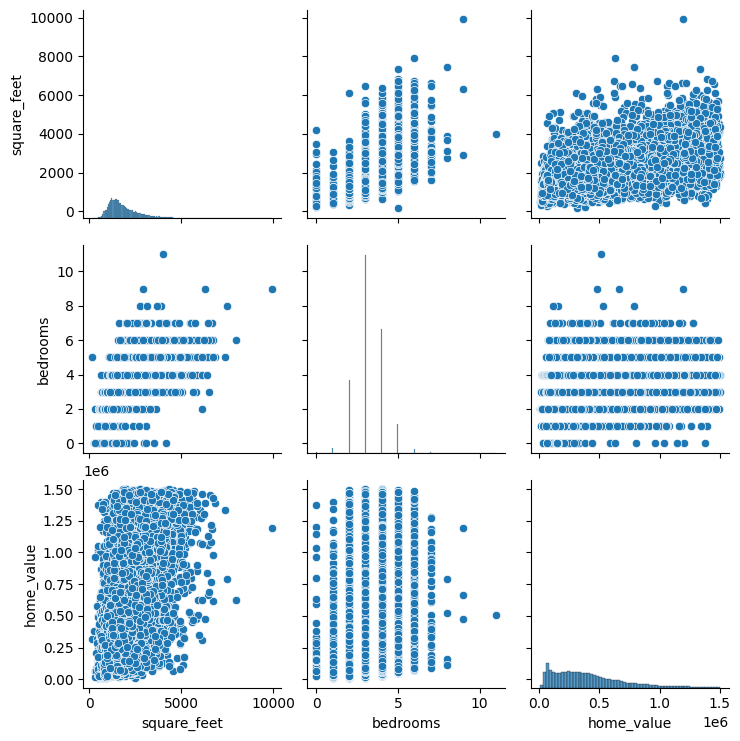

In [6]:
# Create a pairplot to visualize the relationships between the variables in the train set
sns.pairplot(train)

### Findings:
#### 1. It appears that both square_feet and bedrooms have some relationship with the home_value,

#### 2. The bedrooms relationship to home_value is extremely weak

#### 3. The square_feet relationship to home_value is very strong

#### 2. Bedrooms and square_feet have some degree of multicolinearity, however there is high variance in the relationship so both features will still be taken to modeling

#
# Modeling

In [7]:
# Scale the data using a MinMaxscaler
X_train, X_validate, X_test = wrangle.scale_zillow(X_train, X_validate, X_test)

In [8]:
results_df = model.build_regression_models(X_train, y_train, X_validate, y_validate, X_test, y_test)



15 regression models were successfully generated.
    
Yellow: the three models with the lowest train-validate difference (green may overlap with these and leave only two yellow rows)
Red: the baseline plus all models within one percent of the baseline rmse
Green: either the model with the lowest train-validate difference or a model with a very low train-validate difference and the lowest validate rmse


,model,rmse_train,rmse_validate,r_validate,model_difference
0,Mean Baseline,300285.660000,302875.000000,0.000000,2588.950000
1,OLS,251966.090000,251045.320000,0.310000,920.770000
2,LassoLars_a0.01,254361.050000,253390.640000,0.300000,970.407979
3,LassoLars_a0.02,254361.050000,253390.650000,0.300000,970.405349
4,LassoLars_a0.03,254361.060000,253390.660000,0.300000,970.402718
5,LassoLars_a0.04,254361.070000,253390.670000,0.300000,970.400088
6,LassoLars_a0.05,254361.070000,253390.680000,0.300000,970.397458
7,Tweedie_a0.01,260170.810000,257922.130000,0.270000,2248.680000
8,Tweedie_a0.02,260170.810000,257922.130000,0.270000,2248.680000
9,Tweedie_a0.03,260170.810000,257922.130000,0.270000,2248.680000



Examine the above models and determine the best one for your purposes.
Generally, a green model will perform the best.



#### Visualize model performance

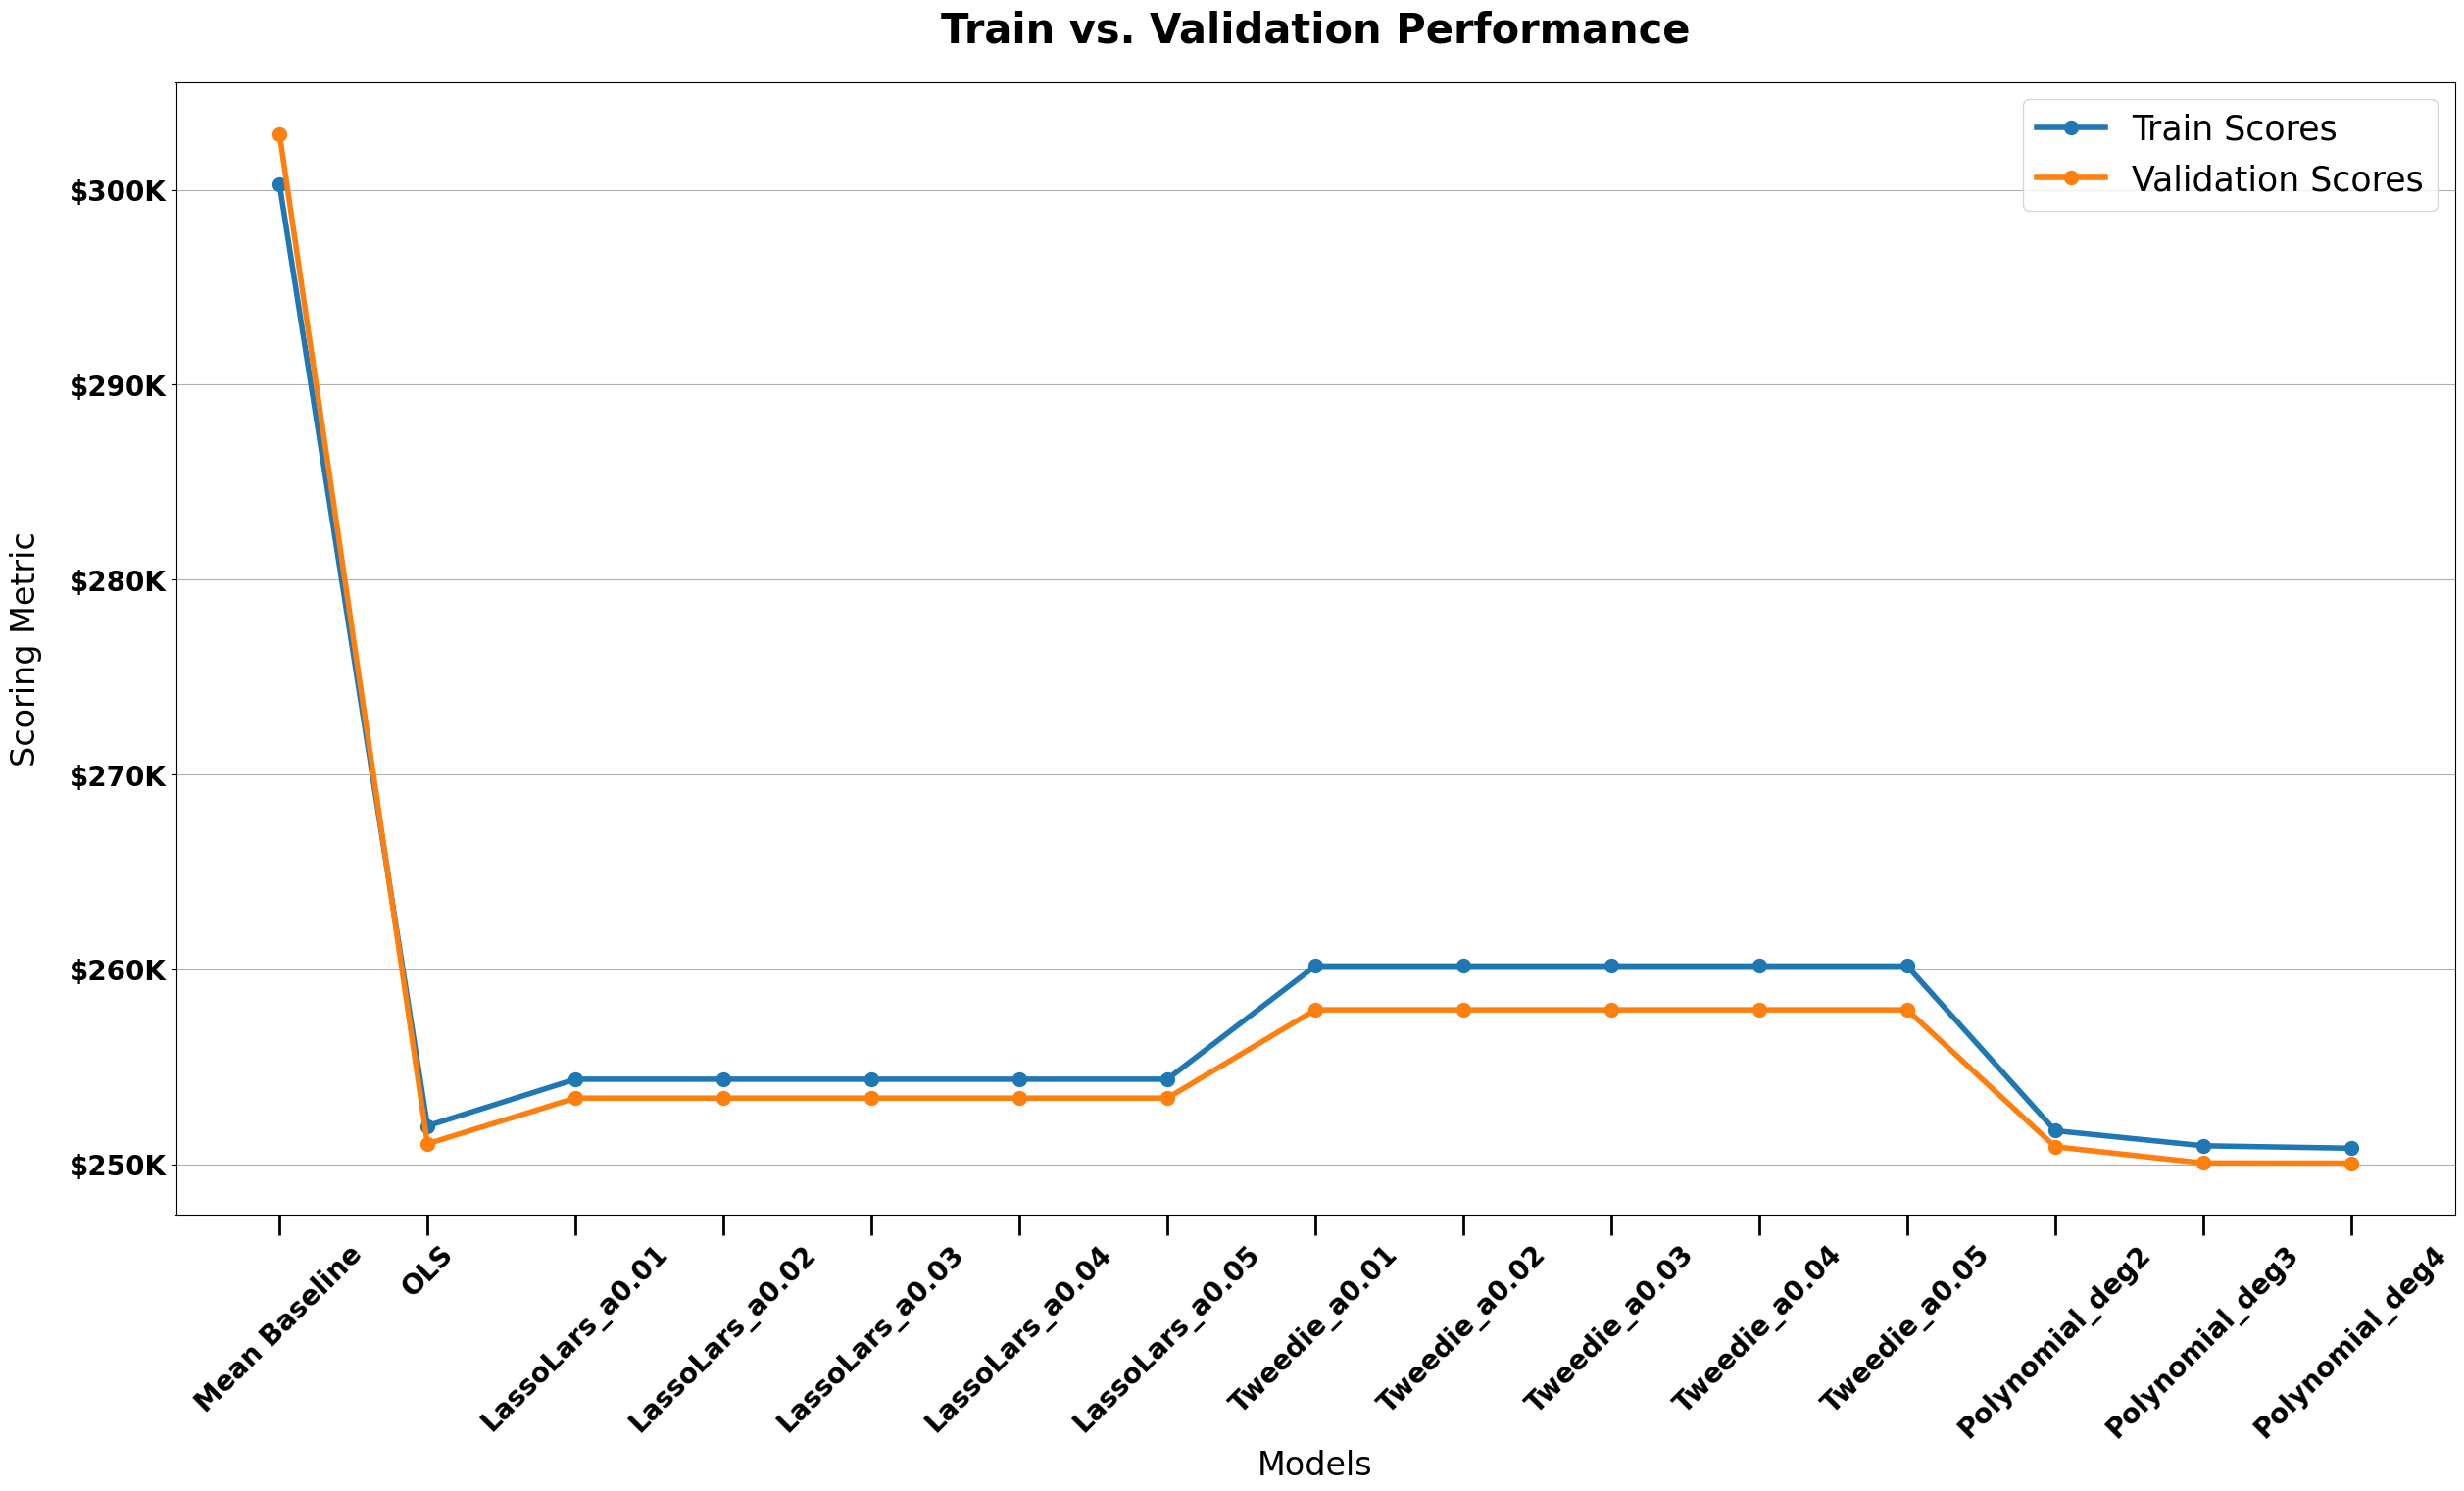

In [9]:
 model.visualize_model_performance(results_df)

#### Evaluate the best model (polynomial_deg3) on the test data set

In [10]:
# Polynomial Model with degree=3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_validate_poly = poly.transform(X_validate)
X_test_poly = poly.transform(X_test)

# Fit the polynomial regression model on the train set
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train.home_value)

coefficients = poly_reg.coef_
intercept = poly_reg.intercept_

# Make predictions on the train, validate, and test sets
y_train['value_pred_poly'] = poly_reg.predict(X_train_poly)
rmse_train = mean_squared_error(y_train.home_value, y_train.value_pred_poly) ** 0.5

y_validate['value_pred_poly'] = poly_reg.predict(X_validate_poly)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.value_pred_poly) ** 0.5

y_test['value_pred_poly'] = poly_reg.predict(X_test_poly)
rmse_test = mean_squared_error(y_test.home_value, y_test.value_pred_poly) ** 0.5

# Append the evaluation metrics of the best model to the final_df dataframe
final_df = pd.DataFrame(data={
    'model': ['Polynomial_deg3'],
    'rmse_train': [rmse_train],
    'rmse_validate': [rmse_validate],
    'rmse_test': [rmse_test],
    'r_test': [explained_variance_score(y_test.home_value, y_test.value_pred_poly)],
    'model_difference': [abs(rmse_validate - rmse_train)]
})

# Print the final evaluation dataframe
display(final_df)

,model,rmse_train,rmse_validate,rmse_test,r_test,model_difference
0,Polynomial_deg3,250945.36111,250059.617901,250957.491589,0.312679,885.743209


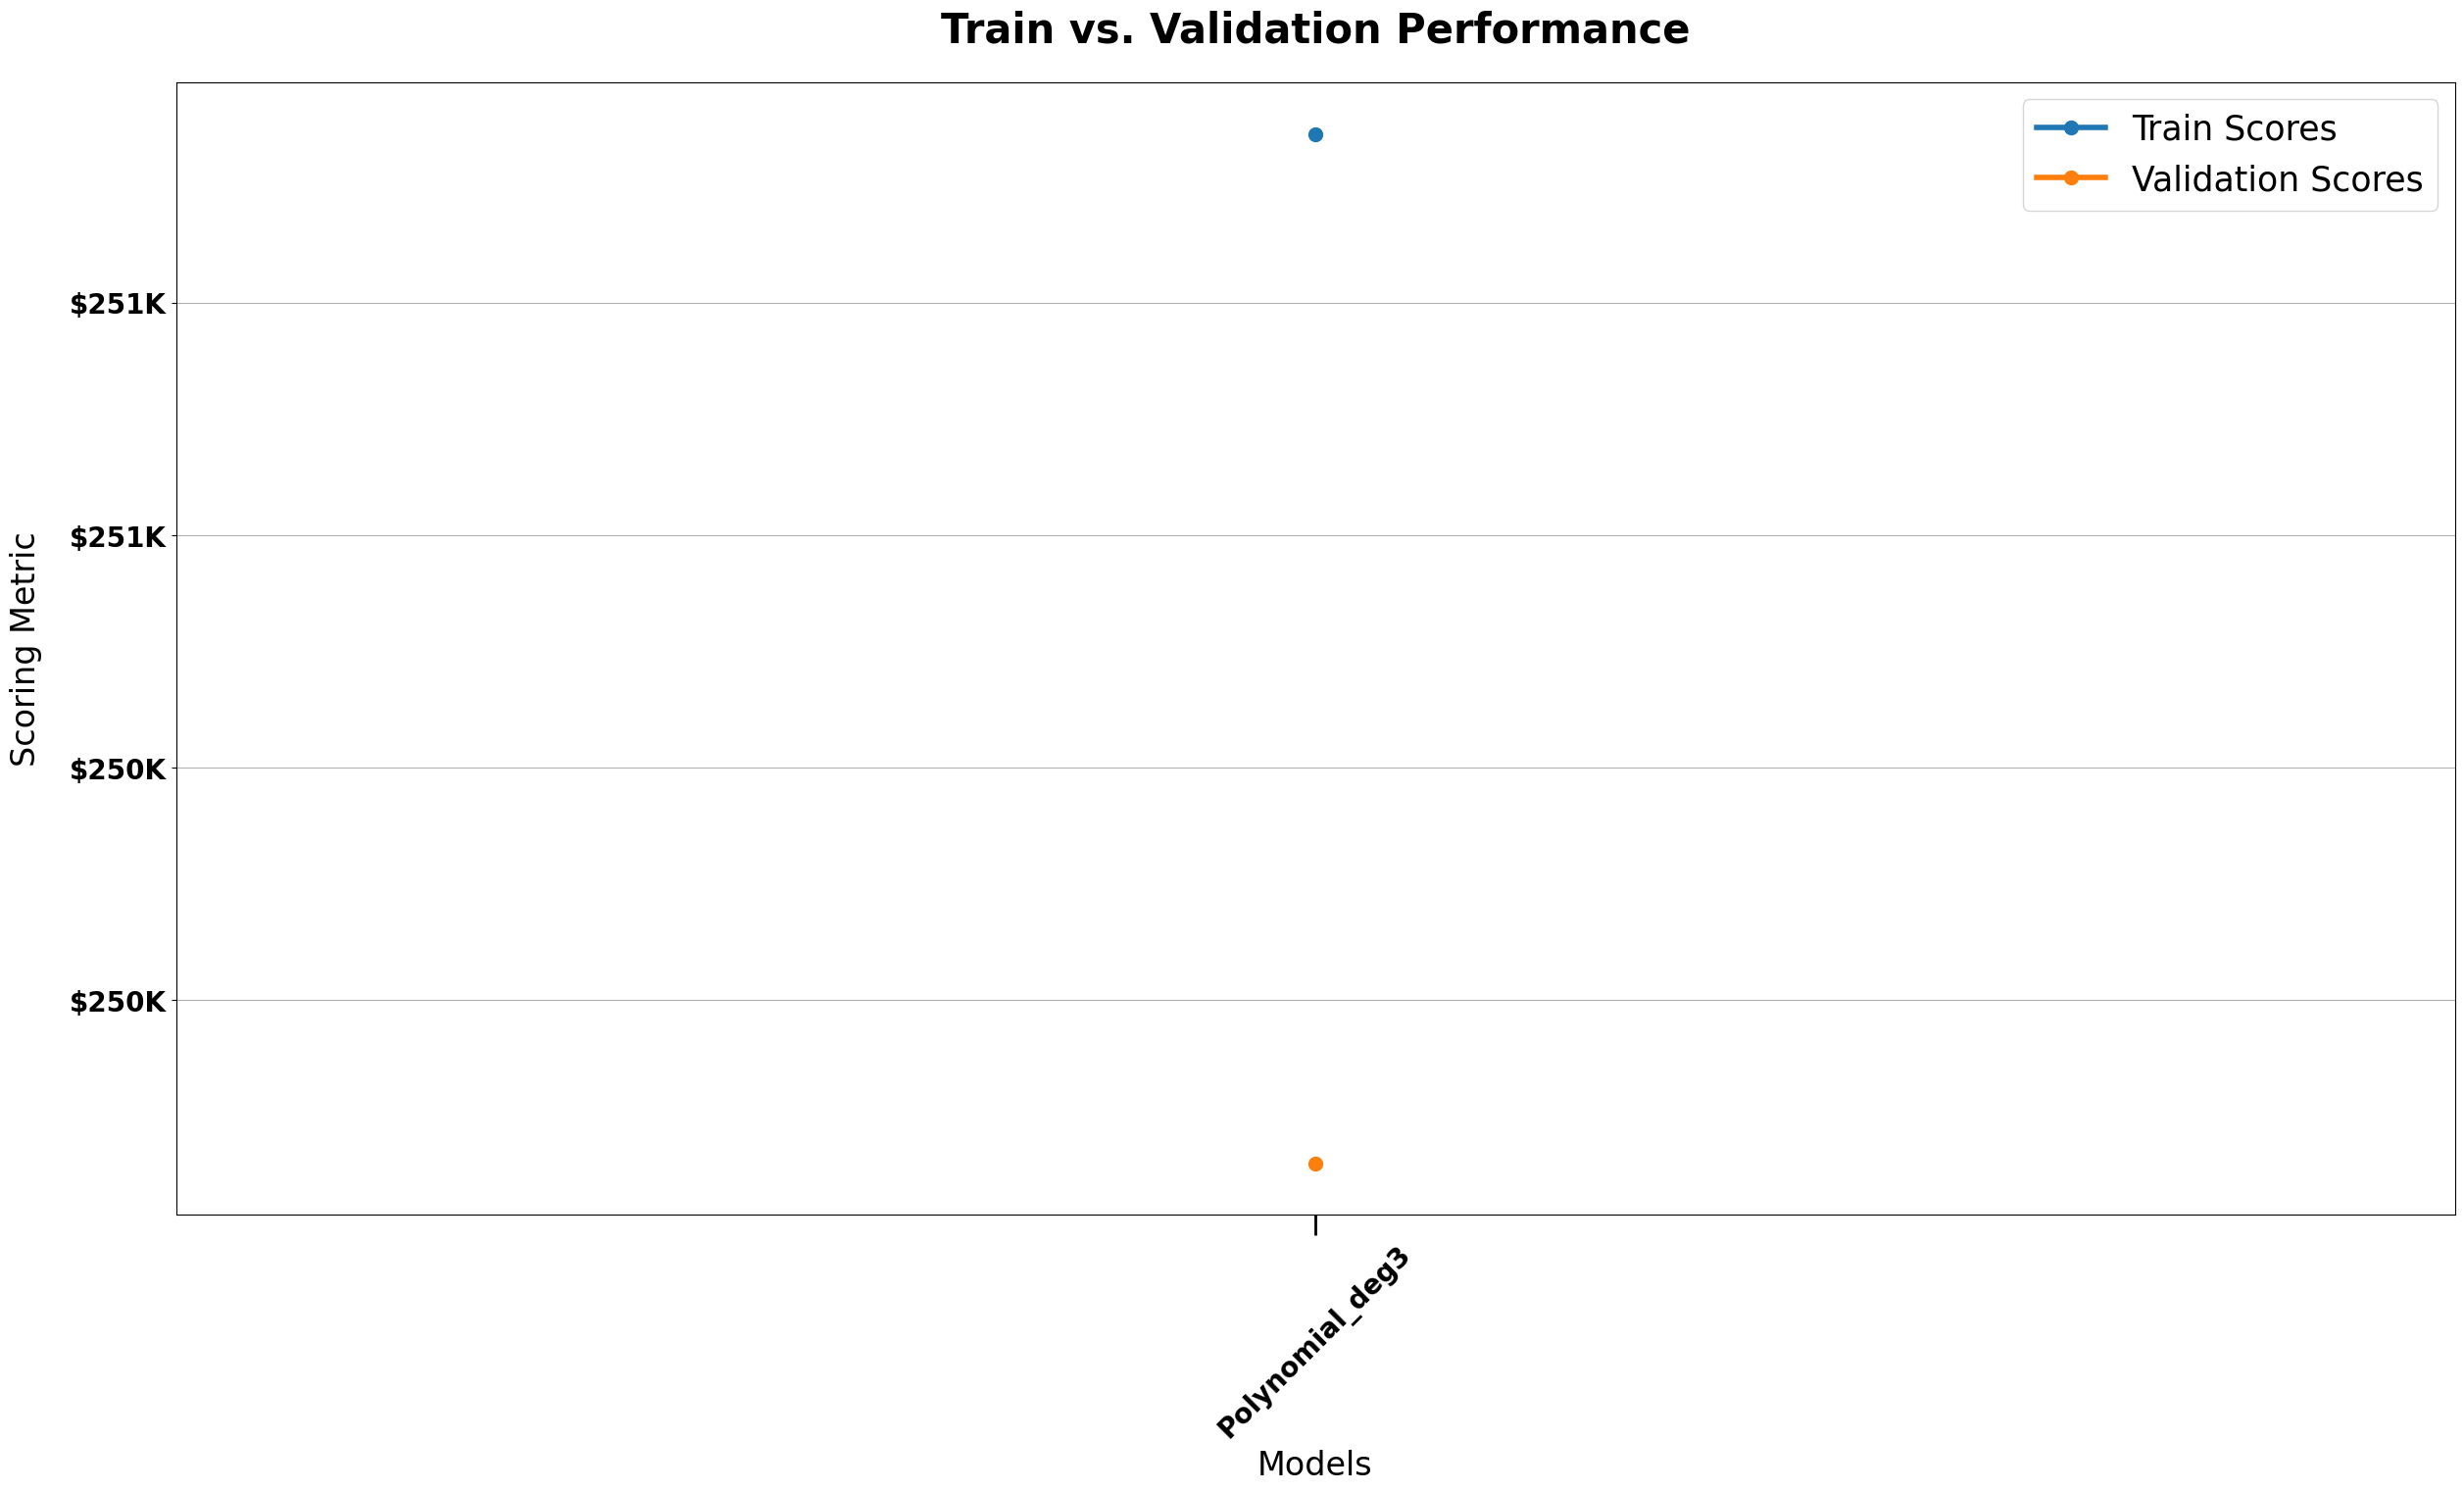

In [11]:
train_scores = final_df.rmse_train.tolist()
val_scores = final_df.rmse_validate.tolist()
models = final_df.model
# Plot the train performance and validate performance of each model, with formatting
plt.figure(figsize=(30, 15))
plt.plot(models, train_scores, marker='o', markersize=10, label='Train Scores', linewidth=4)
plt.plot(models, val_scores, marker='o', markersize=10, label='Validation Scores', linewidth=4)
plt.xticks(rotation=45, fontsize=20, fontweight='bold')
plt.tick_params(axis='x', which='both', length=15, width=2)
plt.yticks(fontsize=20, fontweight='bold')
plt.gca().set_yticklabels(["${:,.0f}K".format(label / 1000) for label in plt.gca().get_yticks()])
plt.xlabel('Models', fontsize=24)
plt.ylabel('Scoring Metric', fontsize=24, labelpad=20)
plt.title('Train vs. Validation Performance', fontsize=30, fontweight='bold', pad=30)
plt.legend(prop={'size': 25})
plt.grid(axis='y')
print('''
''')
plt.show()

In [12]:
y_test['baseline'] = y_test.home_value.mean()

In [13]:
y_test.head()y

SyntaxError: invalid syntax (1602967655.py, line 1)

In [ ]:
import matplotlib.pyplot as plt

# Get the predicted values of the model
model_predictions = y_test.value_pred_poly.tolist()

# Get the actual values
actuals = y_test.home_value.tolist()

# Get the baseline predictions
baseline_predictions = y_test.baseline.tolist()


# Create the x-axis values (e.g., data point indices)
x_values = range(len(model_predictions))

# Plot the model's predictions
plt.scatter(x_values, model_predictions, color='blue', label='Model Predictions')

# Plot the baseline predictions
plt.scatter(x_values, baseline_predictions, color='red', label='Baseline Predictions')

# Add labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Prediction')
plt.title('Model Performance vs. Baseline')

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape X_train and X_validate to have two dimensions
X_train_reshaped = X_train['square_feet'].values.reshape(-1, 1)
X_validate_reshaped = X_validate['square_feet'].values.reshape(-1, 1)

# Generate x values for plotting
x_plot = np.linspace(min(X_train['square_feet']), max(X_train['square_feet']), 100)
x_plot_reshaped = x_plot.reshape(-1, 1)

# Create polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_reshaped)
X_validate_poly = poly.transform(X_validate_reshaped)
x_plot_poly = poly.transform(x_plot_reshaped)

# Fit the polynomial regression model on the train set
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Predict y values using the polynomial regression model
y_plot = poly_reg.predict(x_plot_poly)

# Plot the original data points
plt.scatter(X_train['square_feet'], y_train, color='blue', label='Training Data')
plt.scatter(X_validate['square_feet'], y_validate, color='green', label='Validation Data')

# Plot the line of best fit
plt.plot(x_plot, y_plot, color='red', label='Line of Best Fit')

# Add labels and title
plt.xlabel('Square Feet')
plt.ylabel('Home Value')
plt.title('Polynomial Regression - Line of Best Fit')

# Add a legend
plt.legend()

# Display the plot
plt.show()
